London bike sharing dataset
========
While exploring datasets on kaggle this one about bike share counts in London caught my eye. As someone who frequently commutes by bike in Denver I thought it'd be interesting to see what trends and predictions I could make given hourly counts and weather information found in this dataset.

The data from cycling dataset is grouped by "Start time", this represent the count of new bike shares grouped by hour. The long duration shares are not taken in the count.

Metadata:
---

"timestamp" - timestamp field for grouping the data  
"cnt" - the count of a new bike shares  
"t1" - real temperature in C  
"t2" - temperature in C "feels like"  
"hum" - humidity in percentage  
"wind_speed" - wind speed in km/h  
"weather_code" - category of the weather  
"is_holiday" - boolean field - 1 holiday / 0 non holiday  
"is_weekend" - boolean field - 1 if the day is weekend  
"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.  

"weather_code" category description:  
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity  
2 = scattered clouds / few clouds  
3 = Broken clouds  
4 = Cloudy  
7 = Rain/ light Rain shower/ Light rain  
10 = rain with thunderstorm  
26 = snowfall  
94 = Freezing Fog  


In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score

## Loading the data
The first step is to load the data and perform some basic cleaning. The dataset is in rather good condition so not much cleaning is required. However, it may be helpful to reformat certain columns into more friendly datatypes for further analysis. Additionally, expanding certain features such as 'timestamp' into separate columns allows for easier use in models.

In [5]:
# import data
bikeshare_data = pd.read_csv("data/london_merged_hour.csv")

# reformat timestamp
bikeshare_data['timestamp'] = pd.to_datetime(bikeshare_data['timestamp'])

# create new columns for date and time data
bikeshare_data['date'] = bikeshare_data['timestamp'].dt.normalize()
bikeshare_data['day_of_week'] = bikeshare_data['timestamp'].dt.dayofweek
bikeshare_data['hour'] = bikeshare_data['timestamp'].dt.hour

# rename columns
bikeshare_data = bikeshare_data.rename(columns={
    'cnt': 'count',
    't1': 'temperature_actual',
    't2': 'temperature_feels_like',
    'hum': 'humidity',
    'weather_code': 'weather_condition_code',
    'wind_speed': 'wind_speed',
    'is_holiday': 'is_holiday',
    'is_weekend': 'is_weekend',
    'season': 'season',
    'date': 'date'
})

# weather code
weather_code_map = {
    1:  "Clear or Fog",
    2:  "Few Clouds",
    3:  "Broken Clouds",
    4:  "Cloudy",
    7:  "Light Rain",
    10: "Thunderstorm with Rain",
    26: "Snowfall",
    94: "Freezing Fog"
}

# include weather description for each entry
bikeshare_data['weather_description'] = bikeshare_data['weather_condition_code'].map(weather_code_map)


## Hypothesis
Given the amount of weather information included in this dataset, my first assumptions would be that given poor weather, ridership would be lower. Or vice versa, given favorable weather, more people would chose to utilize the bike share to get to work.

## Data visualization
To get an understanding of the dataset and what features may be useful in a model, I created some basic visualizations such as a correlation heatmap and pairplots. This will help show what features correlate to counts.

<Figure size 640x480 with 0 Axes>

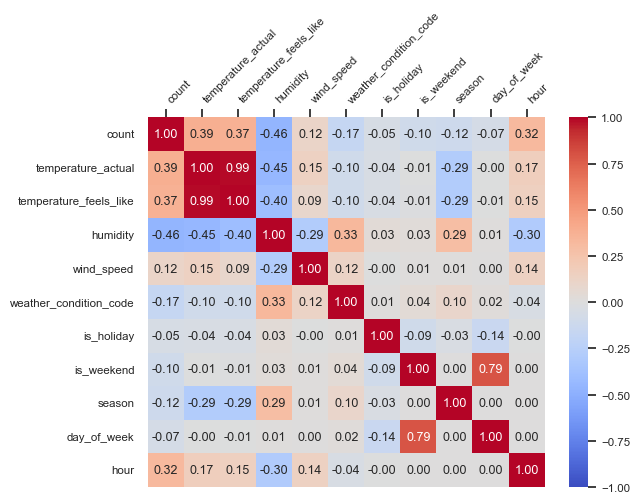

<Figure size 640x480 with 0 Axes>

In [6]:
sns.set_theme(font_scale=.75)
sns.color_palette("coolwarm", as_cmap=True)
hm = sns.heatmap(data=bikeshare_data.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, center=0, cmap=sns.color_palette("coolwarm", as_cmap=True), fmt='.2f')

hm.xaxis.set_ticks_position('top')
hm.xaxis.set_label_position('top')
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)

plt.figure()

As expected, certain weather features show some correlation to counts although not as high as expected.

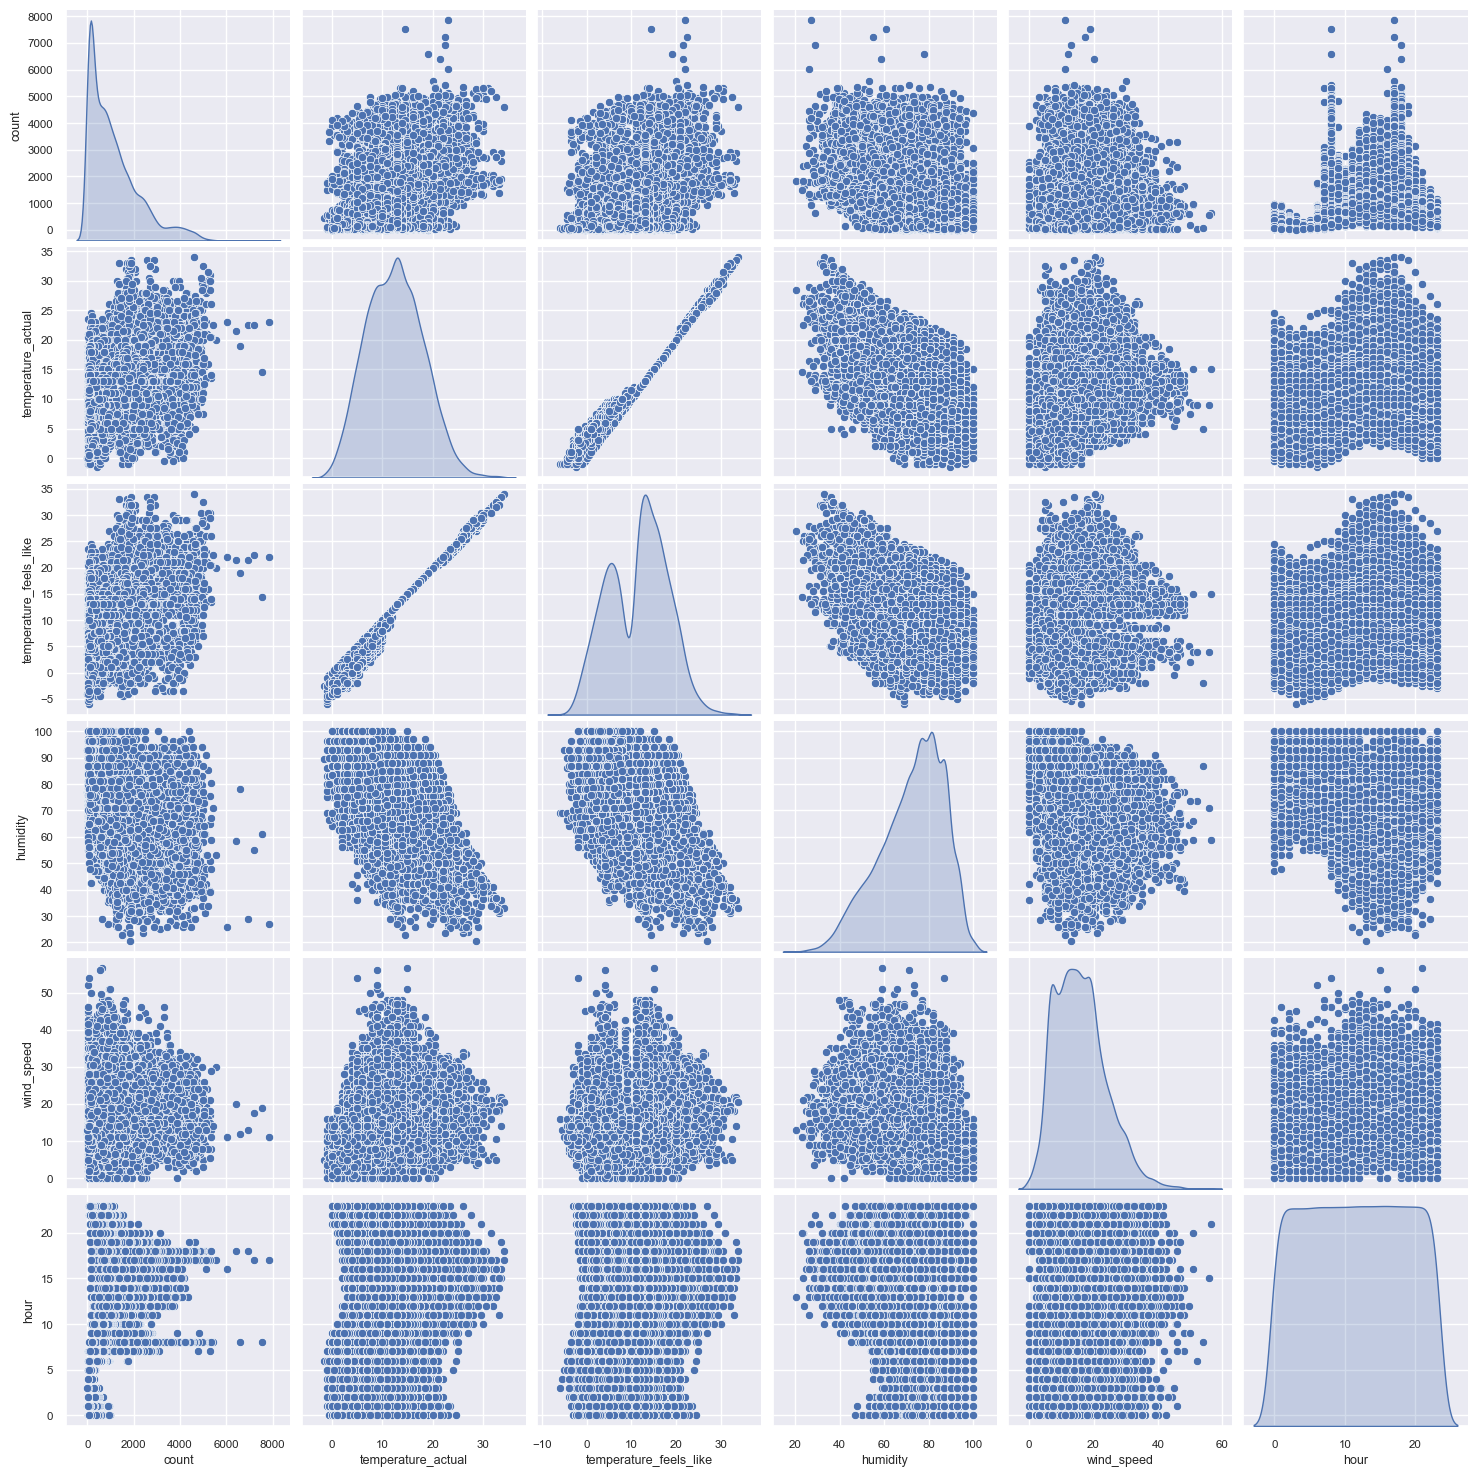

In [7]:
pair_plot_columns = ['count', 'temperature_actual', 'temperature_feels_like', 'humidity', 'wind_speed', 'hour']

sns.pairplot(bikeshare_data[pair_plot_columns], diag_kind='kde')
plt.show()

To get a general idea of when riders are choosing to utilize the bike share.


As expected, there are slightly higher counts at 8am and 5pm indicating commuter use.

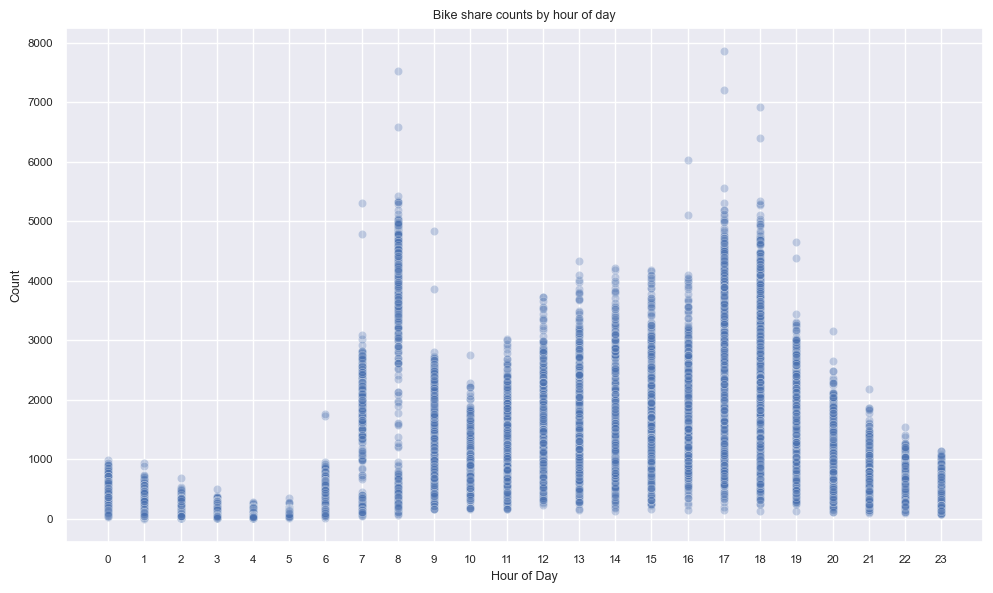

In [73]:
# scatter plot of counts by hour
plt.figure(figsize=(10,6))
sns.scatterplot(data=bikeshare_data, x='hour', y='count', alpha=0.3)
plt.title('Bike share counts by hour of day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

## Models

Given that most variable types are numeric such as certain weather indicators, it made sense to start with basic linear regression models.

As shown below, using a single feature such as 'temperature_actual' proved to be a pretty poor predictor for ridership counts. Despite showing the highest correlation to count from other features, it wasn't a very accurate predictor of counts.

Utilizing multiple weather features including 'temperature_actual, humidity, and wind speed' didn't fair much better.



Note - despite temperature_feels also showing a relatively high correlation to count it was not included since temperature_actual and temperature_feels are highly correlated

In [74]:
# create training and test sets
X_train, X_test = train_test_split(bikeshare_data, test_size=0.20)

# run a simple linear regression model using temp_actual as the predictor
model = smf.ols(formula='count ~ temperature_actual', data=X_train)

model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     2437.
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        12:33:35   Log-Likelihood:            -1.1600e+05
No. Observations:               13931   AIC:                         2.320e+05
Df Residuals:                   13929   BIC:                         2.320e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            209.2386     20

In [75]:
# run a multilinear regression model using multiple features
model_multi = smf.ols(formula='count ~ temperature_actual + humidity + wind_speed', data=X_train)

model_multi = model_multi.fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     1584.
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        12:33:35   Log-Likelihood:            -1.1508e+05
No. Observations:               13931   AIC:                         2.302e+05
Df Residuals:                   13927   BIC:                         2.302e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2632.9448     63

Another model may be better suited than simple regression models. Using a decision tree regression when correlation between the features and target isn't linear may prove to be a better model.

In [11]:
# create datasets
X = bikeshare_data.drop(columns=['count', 'timestamp', 'date', 'weather_description'])
X = X.select_dtypes(include='number')

y = bikeshare_data['count']

# create training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

# evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

sorted_features = sorted(zip(X.columns, regressor.feature_importances_), key=lambda x: x[1], reverse=True)

print('\n')

print("Feature Importance:")

for f, i in sorted_features:
    print(f"{f}: {i:.4f}")

Root Mean Squared Error: 317.60
R² Score: 0.916


Feature Importance:
hour: 0.7213
temperature_feels_like: 0.0762
day_of_week: 0.0442
is_weekend: 0.0391
humidity: 0.0351
is_holiday: 0.0215
weather_condition_code: 0.0197
temperature_actual: 0.0178
wind_speed: 0.0152
season: 0.0099


This proves to be a much more accurate model with a higher Rsquared. Looking at the list of feature importance, hour is of much more importance than any weather variable.

We can likely improve this model by using a Random Forest Regressor which combines multiple decision trees.

In [13]:
# random forest model
bikeshare_data_model = bikeshare_data.drop(columns=['timestamp', 'date', 'weather_description'])

# setup the features and target
X = bikeshare_data_model.drop(columns=['count'])
y = bikeshare_data_model['count']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

sorted_features_rf = sorted(zip(X.columns, rf.feature_importances_), key=lambda x: x[1], reverse=True)

print('\n')

print("Feature Importance:")

for f, i in sorted_features_rf:
    print(f"{f}: {i:.4f}")

RMSE: 237.36
R² Score: 0.9530


Feature Importance:
hour: 0.7133
temperature_actual: 0.0483
temperature_feels_like: 0.0474
day_of_week: 0.0438
is_weekend: 0.0430
humidity: 0.0413
is_holiday: 0.0203
weather_condition_code: 0.0183
wind_speed: 0.0142
season: 0.0101


Using a Random Forest Regressor improves the Rsquared slightly and produces a lower RMSE.

## Conclusions
It's clear that my original hypothesis is incorrect. Weather does not seem to have a meaningful effect on ridership. It appears that the time which a bike is rented is a much stronger indicator of counts. I.e. riders are using the bike share to commute to work at regular times regardless of weather. I'd assume most of these trips are essential which explains why weather factors don't have a strong effect on counts.

This result makes me curious what the outcome would be if we removed trips that are likely "essential" i.e. commutes to work and only include non-essential trips. While there isn't an exact way to create this subset of data. An easy way would be to exclude weekday trips and only look at weekends, where one could assume that more trips are non-essential and the mode of transportation is more flexible.

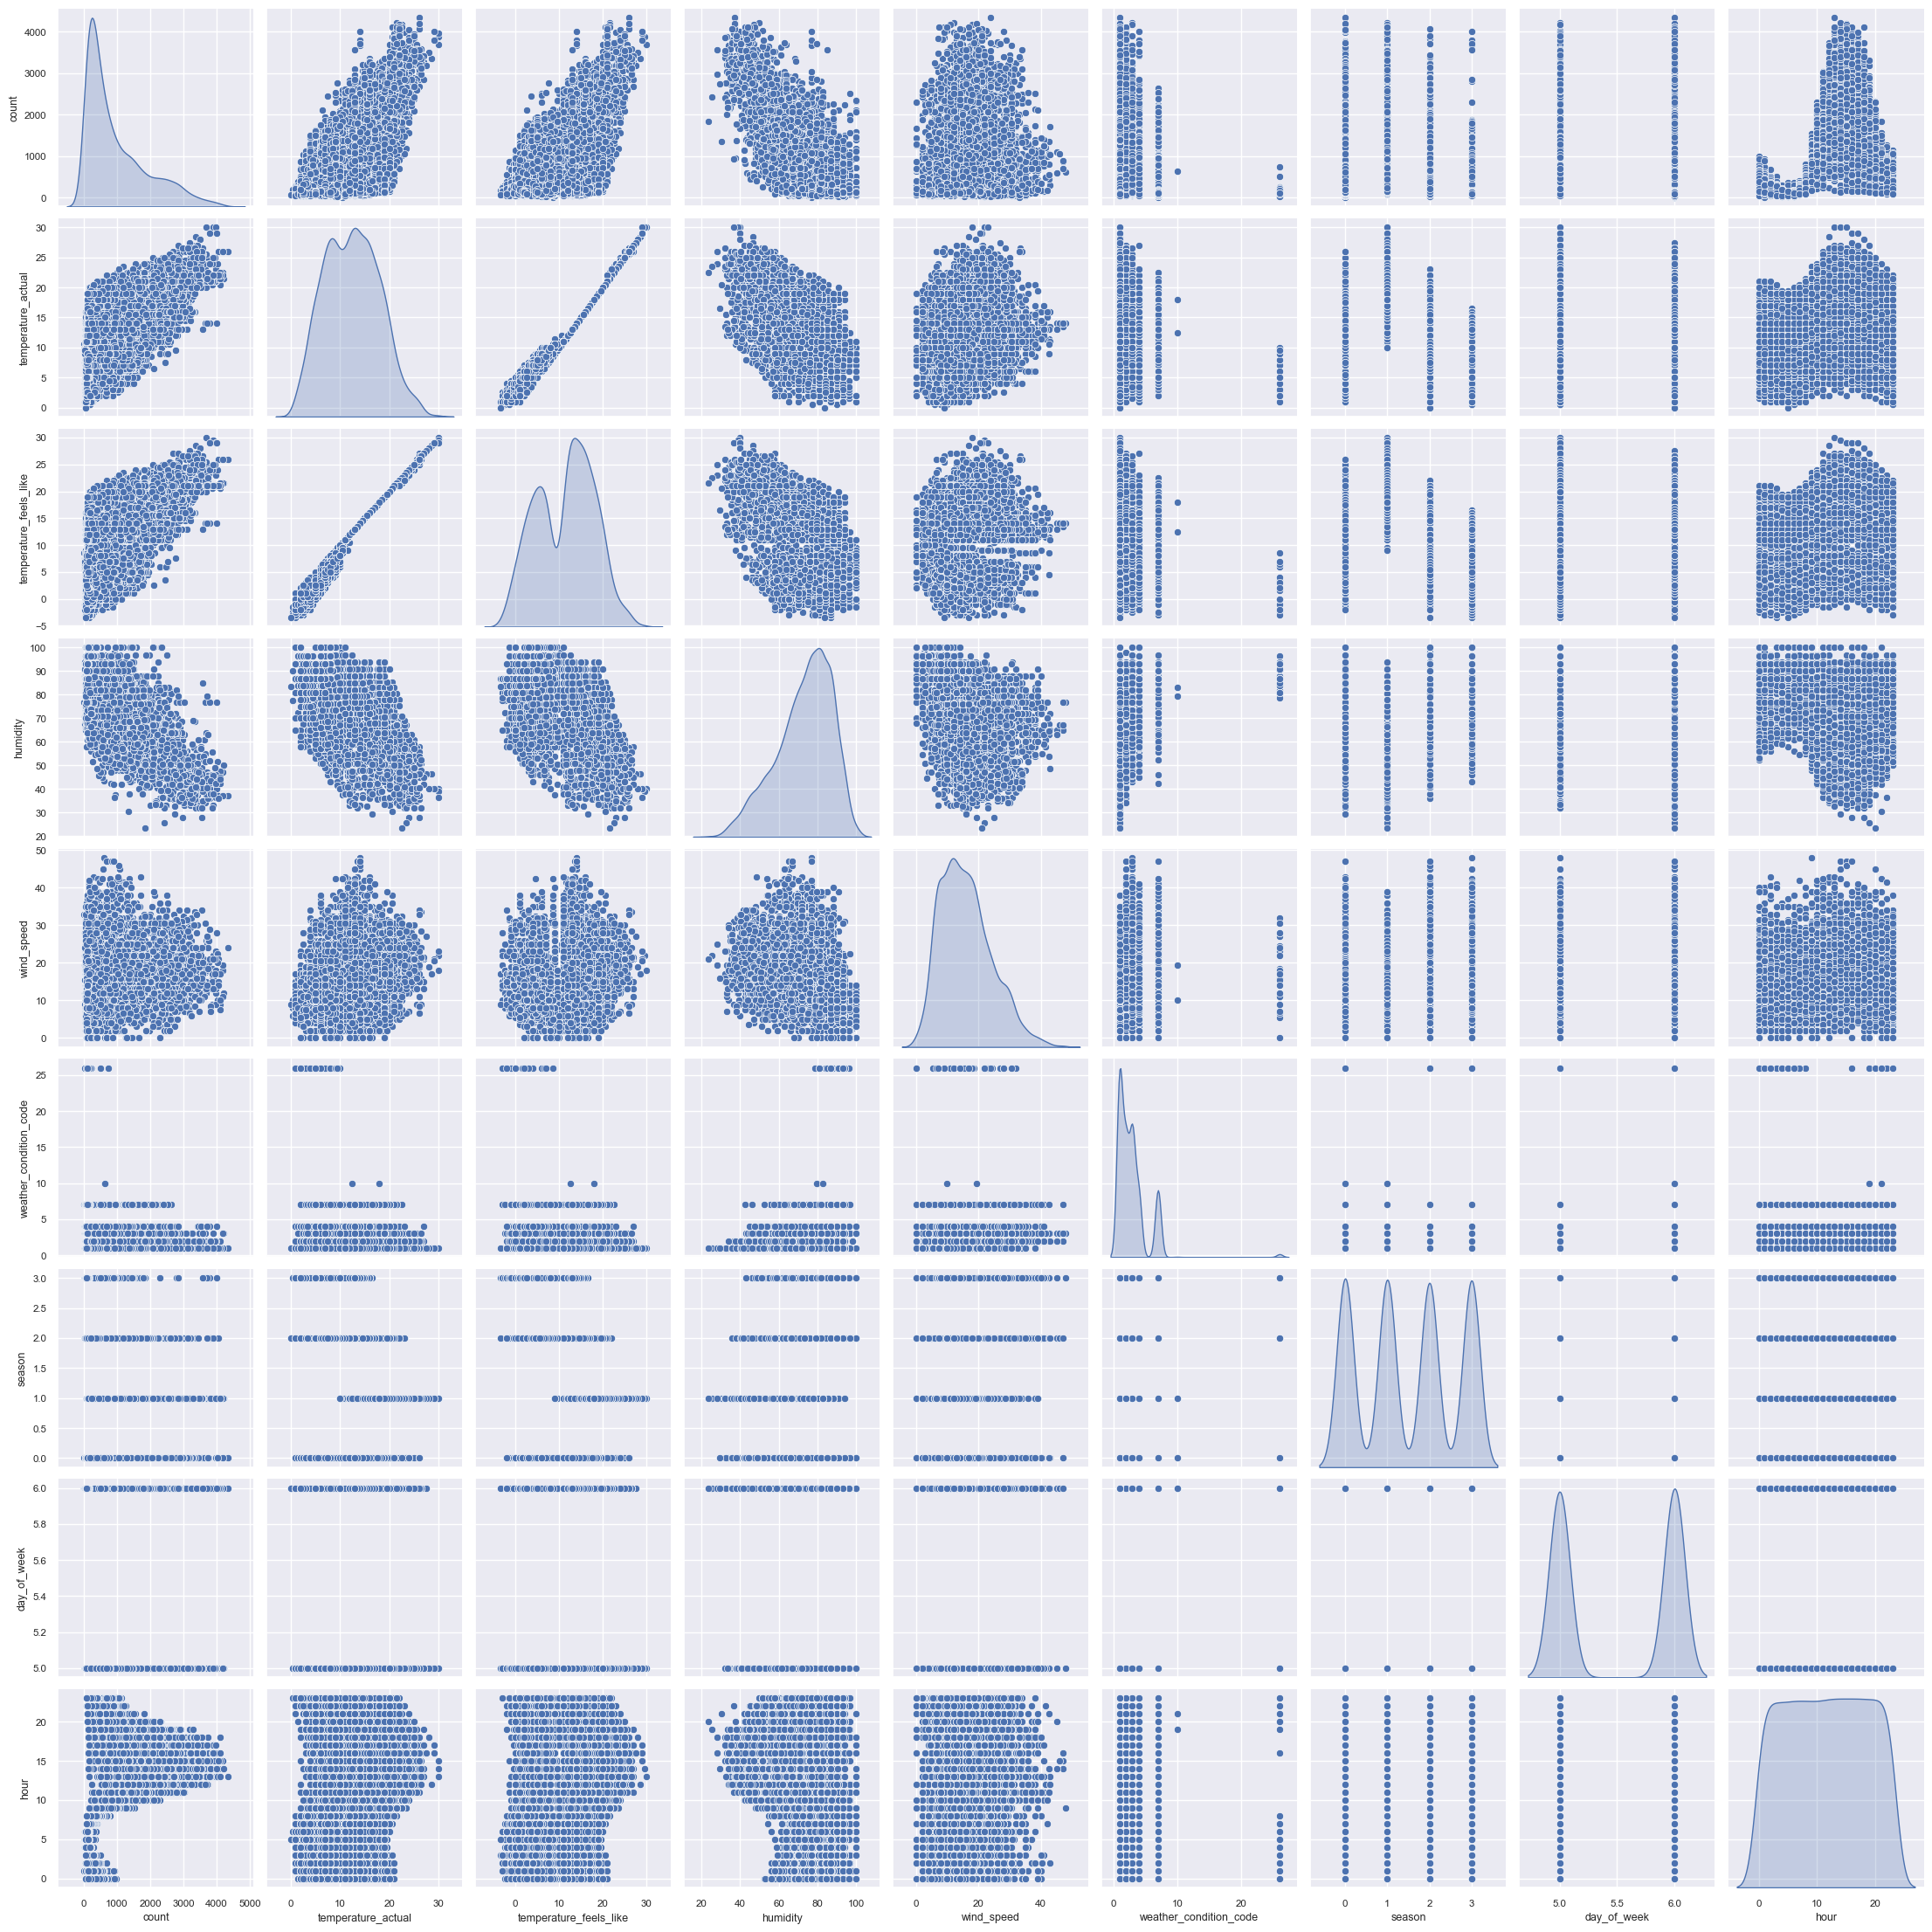

In [14]:
# select only weekend days
bikeshare_data_weekend = bikeshare_data[(bikeshare_data['is_weekend'] == 1)].copy()

bikeshare_data_weekend.drop(columns=['is_holiday', 'is_weekend'], inplace=True)

numeric_cols_weekend = bikeshare_data_weekend.select_dtypes(include='number')

# Create pair plot
sns.pairplot(numeric_cols_weekend, diag_kind='kde')
plt.show()

<Figure size 640x480 with 0 Axes>

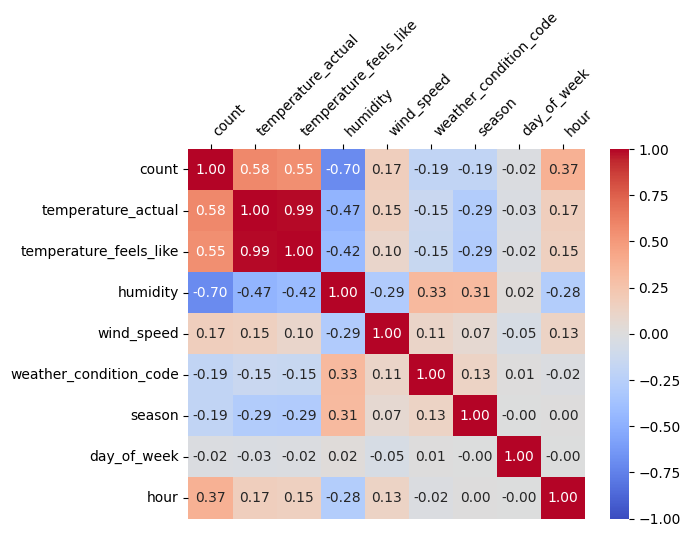

<Figure size 640x480 with 0 Axes>

In [ ]:
hm_weekend = sns.heatmap(data=bikeshare_data_weekend.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, center=0, cmap=sns.color_palette("coolwarm", as_cmap=True), fmt='.2f')

hm_weekend.xaxis.set_ticks_position('top')
hm_weekend.xaxis.set_label_position('top')
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)

plt.figure()

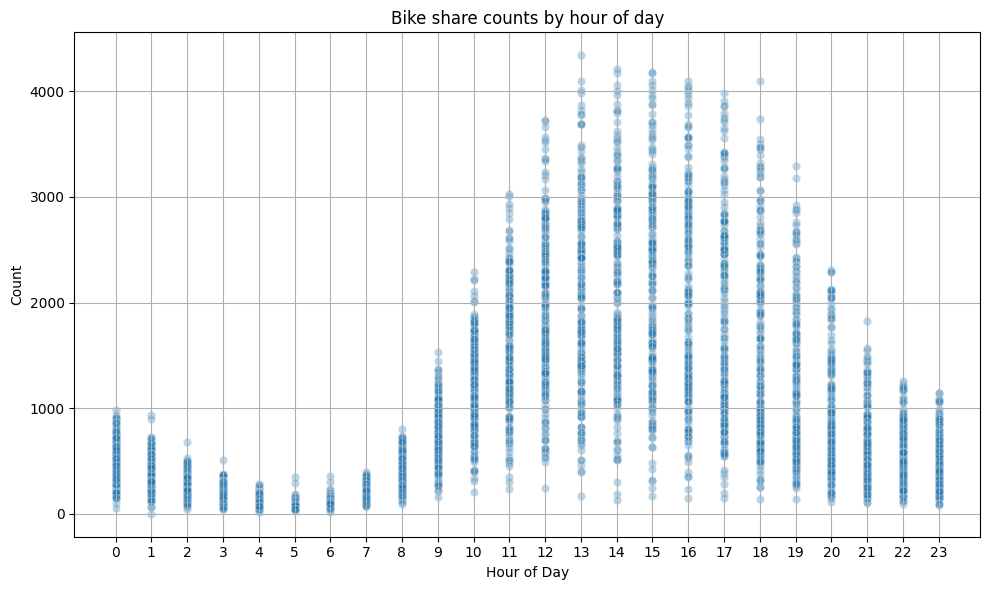

In [50]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=bikeshare_data_weekend, x='hour', y='count', alpha=0.3)
plt.title('Bike share counts by hour of day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

Excluding weekdays, weather features appear to show a stronger correlation to count than including all data. Additionally those weather features show a more linear correlation to count that prior.

In [15]:
# using a subset of data run our multilinear regression using multiple features
model_weekend = smf.ols(formula='count ~ temperature_actual + humidity + wind_speed + hour', data=bikeshare_data_weekend)

model_weekend = model_weekend.fit()
print(model_weekend.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     1910.
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        13:00:36   Log-Likelihood:                -38682.
No. Observations:                4970   AIC:                         7.737e+04
Df Residuals:                    4965   BIC:                         7.741e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2618.2850     71

While a significant improvement over the original linear model, I wouldn't consider this model a good fit since the Rsquared is still too low. Further analysis could be done using this subset of data, but as mentioned previously there's isn't an exact way to segment the data.